## TP 3.1 : Jeu de la minorité avec nombre variable d’agents

*Notebook fait par Alexandre Boistard, Ethan Trentin.*

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from numba import jit

Le modèle le plus simple est défini de la façon suivante :
- $N_s$ spéculateurs possèdent chacun une stratégie $a_i^{\mu}, i \in \{−1,+1\}, i = 1,···,N_s, \mu = 1,···,P$.
- On ajoute de la prévisibilité à la main, en supposant que $N_p$ autres agents utilisent leur stratégie
à chaque pas de temps. De façon équivalente, on peut considérer une contribution des producteurs
constante pour un état $\mu$ donné, que l’on dénote $\Omega_{\mu}$. On peut tirer $\Omega_{\mu}$ à partir d’une distribution $\mathcal{N}(0,N_p)$.
- La stratégie du speculateur i est testée en temps réel et sa performance cumulée est assignée à un
scalaire $$U_i(t +1) = U_i(t)−a_i^{\mu(t)}A(t)-\epsilon_i$$
où $A(t) = \Omega^{\mu(t)} + \Sigma_{i=1}^{N_s} n_i(t)a_i^{\mu(t)}, n_i = \Theta[U_i(t)]$ contrôle la participation de l’agent $i$ au jeu, $\Theta$ est la fonction d’Heaviside, et $\epsilon$ est la performance minimale attendue de la stratégie pour que l’agent $i$ la considère comme suffisamment performante et l’utilise.
- La dynamique de $\mu$ peut être considérée ou comme totalement aléatoire ou comme un encodage des
derniers $M$ signes de $A(t)$; dans ce cas, sa dynamique est donnée par
$\mu_{t+1} = 2\mu_t \equiv [2^M] + \Theta[A(t)]$

On nous demande de :
1. programmer efficacement ce modèle dans le langage de notre choix (numpy, numba, cupy, tensorflow,
etc)

In [2]:
# Dans un premier temps, crééons une fonction permettant d'initialiser les stratégies.

def initialize(Ns, P, Np):
    """La fonction initialize prend trois arguments :
    - Ns : le nombre de spéculateurs
    - P : le nombre d'états
    - Np : les autres agents
    On retourne la matrice strategies, la matrice performance, ainsi que le vecteur Omega et le nombre mu."""

    # On initialise les agents avec des stratégies aléatoires entre -1 et 1
    strategies = np.random.choice([-1, 1], size=(Ns, P))
    # On initialise les performances à 0
    performance = np.zeros(Ns)

    # On initialise omega et mu
    Omega = np.random.normal(0, np.sqrt(Np), size=P)
    # On veut générer un nombre entre 0 et P-1 inclus
    mu = np.random.randint(0, P)

    return strategies, performance, Omega, mu

In [3]:
# Maintenant, on définit une fonction pour créer une simulation du jeu, qui va faire appel à la fonction simulation.

def simulation(initialization, Ns, P, Np, M, T, epsilon):
    """La fonction simulation prend 7 arguments :
    - initialization : la fonction d'initialisation
    - Ns : le nombre de spéculateurs
    - P : le nombre d'états
    - Np : le nombre d'autres agents
    - M : le nombre de derniers signes de A(t) considérés
    - T : l'horizon de temps
    - epsilon : la performance minimale
    On retourne le vecteur A_history qui représente l'historique des actions au cours du temps, mu_history qui représente le vecteur des états au cours du temps, et la performance des agents qui est un vecteur."""

    # On passe en argument la fonction d'initialisation, en gardant en mémoire le fait qu'à la question 5 nous devrons utiliser une nouvelle initialisation des stratégies.
    strategies, performance, Omega, mu = initialization(Ns, P, Np)
    A_history = []
    mu_history = []

    for t in range(T):
        # On récupère les actions des stratégies pour l'état mu
        a_mu_t = strategies[:, mu]

        # On détermine les actions des agents en fonction de leur performance à l'aide d'une fonction de Heaviside.
        n_i = (performance >= 0) * 1
        # On calcule l'action A(t) en utilisant la somme des actions des agents et le vecteur Omega
        A_t = Omega[mu] + (n_i * a_mu_t).sum()
        # On rajoute la valeur des actions à l'instant t à l'historique
        A_history.append(A_t)

        # On met à jour la performance
        performance += -a_mu_t * A_t - epsilon

        # On met à jour la valeur de mu : on a deux méthodes disponibles (mettre à jour aléatoirement comme à l'initialisation ou mettre à jour en utilisantt les M derniers signes de A(t), mais nous allons choisir la première méthode puisque la deuxième ne nous donnait pas toujours des résultats cohérents)
        # sign = A_t > 0
        # mu = (2*mu)%2**M + sign
        mu = np.random.randint(0, P)
        mu_history.append(mu)

    return A_history, mu_history, performance

In [4]:
# Une fois qu'on a l'initialisation et la simulation, nous pouvons créer une fonction permettant d'afficher le résultat graphique de la simulation.

def plot_simulation(initialization, Ns, P, Np, M, T, epsilon):
    """La fonction plot_simulation prend 7 arguments :
    - initialization : la fonction d'initialisation
    - Ns : le nombre de spéculateurs
    - P : le nombre d'états
    - Np : le nombre d'autres agents
    - M : le nombre de derniers signes de A(t) considérés
    - T : l'horizon de temps
    - epsilon : la performance minimale
    On affiche le graphique de A(t) au cours du temps."""

    # On récupère l'historique des actions grâce à la fonction simulation.
    A_history, _, _ = simulation(initialization, Ns, P, Np, M, T, epsilon)
    plt.figure(figsize=(10, 5))
    plt.plot([t for t in range(len(A_history))],A_history, label=f'Amplitude de A')
    plt.xlabel('Temps')
    plt.ylabel('A(t)')
    plt.title('Simulation de A(t) au cours du temps')
    plt.legend()
    plt.grid()
    plt.show()

In [7]:
# Définissons maintenant les paramètres du jeu qui ne changeront pas
P = 16 # Le nombre d'états possibles mu, doit être compris dans [10,20] et doit être une puissance de 2.
Np = 16 # Le nombre d'autres agents
M = 3 # La taille de la mémoire (le nombre de signes de A(t) que l'on considère dans la mise à jour de mu dans la première méthode, mais que nous n'allons pas développer ici)

# Les prochains paramètres vont évoluer au cours du notebook
T = 100 # L'horizon temporel
Ns = 10 # Le nombre de spéculateurs
epsilon = 0.01 # La performance minimale pour continuer de participer au jeu

Maintenant, vérifions que nos fonctions sont correctement implémentées.

In [8]:
# On va afficher A_history qui est une série temporelle des actions A(t), mu_history qui représente l'historique des états and les 5 agents les plus performants.
A_history, mu_history, performance = simulation(initialize, Ns, P, Np, M, T, epsilon)
print("Final mu:", mu_history[-1])
print("Final A(t):", A_history[-1])
print(performance)
print("Top 5 performing agents:", np.argsort(performance)[-5:])

Final mu: 13
Final A(t): -2.768114537119099
[-245.32739989  -40.92830134 -141.16511053   -5.98041031   -8.345646
 -152.80486698  -77.71578237    0.62158084 -208.60222623  -37.13473233]
Top 5 performing agents: [1 9 4 3 7]


2. vérifier que l’amplitude de $A(t)$ explose au cours du temps si le nombre de spéculateurs est suffisamment grand, à $P$ et $N_p$ fixes, en traçant $A(t)$ en fonction de $t$ ;

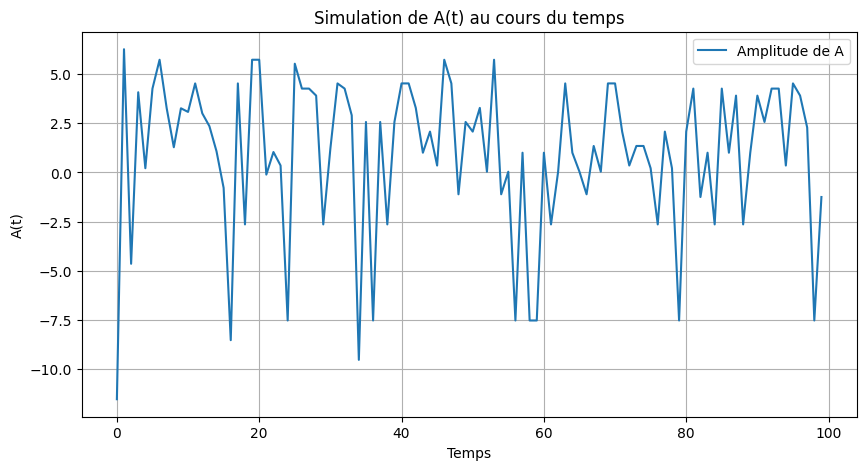

In [9]:
# Déjà, nous allons afficher la simulation pour les paramètres précédents définis.
plot_simulation(initialize, Ns, P, Np, M, T, epsilon)

Commentaires : Nous pouvons constater que pour 10 spéculateurs, l'amplitude des actions A(t) n'explose pas. Maintenant, augmentons le nombre de spéculateurs et essayons d'observer l'explosion de l'amplitude.

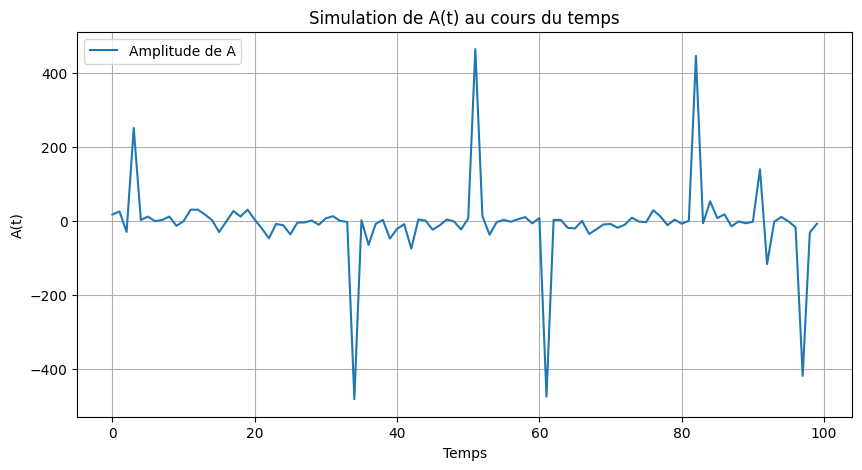

In [10]:
Ns = 1000
plot_simulation(initialize, Ns, P, Np, M, T, epsilon)

Commentaires : L'amplitude de $A(t)$ explose maintenant que nous avons augmenté le nombre de spéculateurs : le système est dans un état transitoire avant d'atteindre son régime stationnaire, dû à la perturbation des spéculateurs.

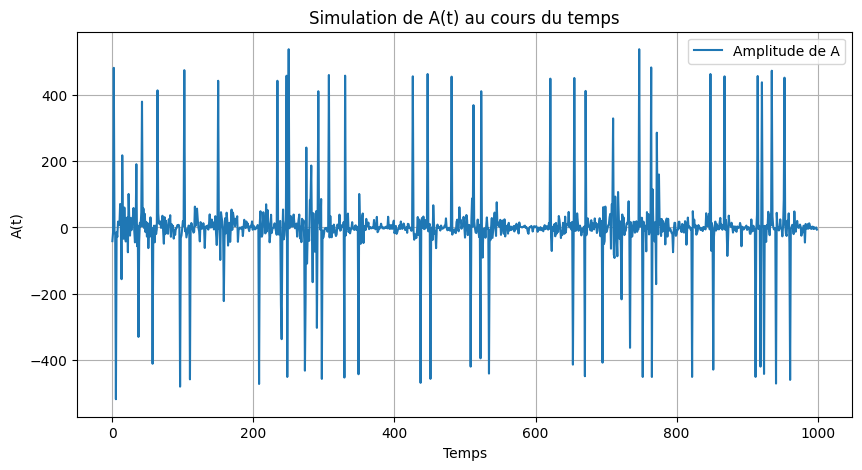

In [11]:
T = 1000
plot_simulation(initialize, Ns, P, Np, M, T, epsilon)

Enfin, on essaye de simuler jusqu'à un horizon de temps suffisamment important pour observer le régime stationnaire. Typiquement, pour être sûr de voir la stationnarité, nous allons observer jusqu'à $\frac{200P}{\epsilon}$.

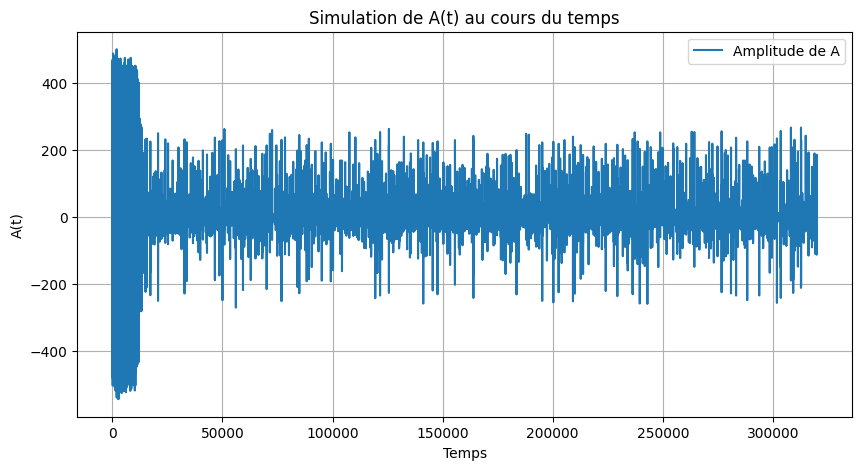

In [12]:
T = int(200*P/epsilon)
plot_simulation(initialize, Ns, P, Np, M, T, epsilon)

Commentaires : on constate sur ce graphique qu'on atteint en réalité assez rapidement le régime stationnaire. Au cours de ce régime, il peut toujours nous arriver d'observer des fluctuations importantes dans l'amplitude, mais leur régularité témoigne du régime stationnaire. Leur présence est attendue puisque nous sommes dans un système dynamique avec des agents interagissants. On peut donc raisonnablement penser que nous pourrons effectuer les moyennes sur les itérations entre $t = 50 000$ et $t = 100 000$.

3. mesurer les fluctuations $\sigma^2 = <A^2>$ et la prévisibilité $H_0 = \sum_{\mu} \frac{<A|\mu>^2}{P}$. Tracer $\frac{\sigma^2}{P}$ et $\frac{H_0}{P}$ en fonction de $n_s = \frac{N_s}{P}$ en fixant $P$ et en faisant varier $N_s$ (10-15 points suffisent). La moyenne est prise sur plusieurs réalisations du jeu pour chaque jeu de paramètres.

In [24]:
# On va créer une version améliorée de la fonction simulation, en compilant avec numba pour diminuer la complexité temporelle des algorithmes.
@jit(nopython=True)
def simulation_numba(strategies, performance, Omega, mu, Ns, P, Np, M, T, epsilon):
    A_history = np.zeros(T)
    mu_history = np.zeros(T, dtype=np.int32)

    for t in range(T):
        a_mu_t = strategies[:, mu]
        n_i = (performance >= 0).astype(np.int32)
        A_t = Omega[mu] + np.sum(n_i * a_mu_t)
        A_history[t] = A_t
        performance += -a_mu_t * A_t - epsilon
        mu = np.random.randint(0, P)
        mu_history[t] = mu

    return A_history, mu_history, performance

In [25]:
def compute_sigma_2_numba(initialization, Ns, P, Np, M, T, epsilon):
    """La fonction compute_sigma_2 prend 7 arguments :
    - initialization : la fonction d'initialisation
    - Ns : le nombre de spéculateurs
    - P : le nombre d'états
    - Np : le nombre d'autres agents
    - M : le nombre de derniers signes de A(t) considérés
    - T : l'horizon de temps
    - epsilon : la performance minimale
    On retourne sigma^2."""
    # Si on comprend sigma^2 comme le crochet de A^2 :
    # sigma2 = 0
    # for i in range(len(A_history)-1):
    #    sigma2 += (A_history[i+1] - A_history[i])**2
    # Sinon, on peut le voir comme la moyenne du carré de A(t) puisque sigma^2 peut être vu comme la variance de A(t) et que la moyenne de A(t) est assez proche de 0 comme nous allons le montrer dans la cellule de code suivante.
    strategies, performance, Omega, mu = initialization(Ns, P, Np)
    A_history, _, _ = simulation_numba(strategies, performance, Omega, mu, Ns, P, Np, M, T, epsilon)
    sigma2 = np.mean(np.square(A_history[50000:]))
    return sigma2

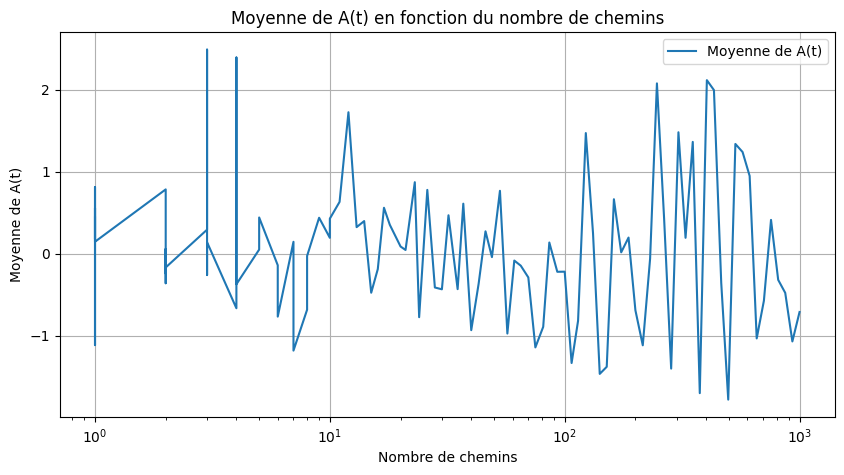

In [37]:
Ns = 10
T = 100
num_paths = np.logspace(0, 3, 100).astype(int)
A_history_mean = []
for num in num_paths:
    for _ in range(num):
        inter = []
        strategies, performance, Omega, mu = initialize(Ns, P, Np)
        A_history, mu_history, performance = simulation_numba(strategies, performance, Omega, mu, Ns, P, Np, M, T, epsilon)
        inter.append(np.mean(A_history))
    A_history_mean.append(np.mean(inter))
plt.figure(figsize=(10, 5))
plt.plot(num_paths, A_history_mean, label=f'Moyenne de A(t)')
plt.xlabel('Nombre de chemins')
plt.ylabel('Moyenne de A(t)')
plt.xscale('log')
plt.title('Moyenne de A(t) en fonction du nombre de chemins')
plt.legend()
plt.grid()
plt.show()

In [31]:
# Définissons une fonction pour afficher sigma^2/P en fonction de ns = Ns/P. Nous allons passer en argument la fonction compute_sigma_2 et la future fonction de previsibilite afin d'avoir le plot général.
def plot_function_ns_numba(function, initialize, Ns, P, Np, M, T, epsilon, num_iterations, title):
    """La fonction prend 10 arguments :
    - function : le nom de la fonction que l'on va utiliser pour afficher soit les fluctuations soit la prévisibilité
    - initialize : la fonction qui permet d'initialiser
    - Ns : le nombre de spéculateurs
    - P : le nombre d'états
    - Np : le nombre d'autres agents
    - M : le nombre de derniers signes de A(t) considérés
    - T : l'horizon temporel
    - epsilon : la performance minimale
    - num_iterations : le nombre d'itérations de l'aglorithme pour effecteur la moyenne
    - title : le nom de la grandeur que l'on affiche sur le graphique
    On affiche le graphique à la fin."""
    grandeur = Parallel(n_jobs=-1)(
        delayed(np.mean)([function(initialize, n, P, Np, M, T, epsilon) for _ in range(num_iterations)])
        for n in Ns
    )
    grandeur = np.array(grandeur) / P

    plt.plot(Ns / P, grandeur)
    plt.xlabel('$n_s$')
    plt.ylabel(title)
    plt.title(f'Simulation de {title} en fonction de $n_s$')
    plt.grid()
    plt.show()


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


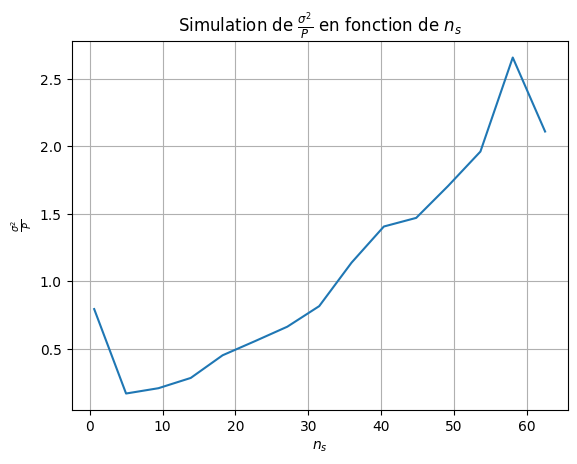

In [32]:
Ns = np.linspace(10, 1000, 15).astype(int)
num_iterations = 100
T = 100000
plot_function_ns_numba(compute_sigma_2_numba, initialize, Ns, P, Np, M, T, epsilon, num_iterations, '$\\frac{\sigma^2}{P}$')

Commentaires : Initialement, pour des valeurs faibles de $n_s$, $\sigma^2$ est relativement bas, suggérant une stabilité accrue du système avec peu de spéculateurs (on a une décroissance initiale des fluctuations). Cependant, à mesure que l'on augmente le nombre de spéculateurs, on observe une augmentation significative des fluctuations, indiquant une volatilité croissante dans le système. Ce comportement semble refléter une dynamique où un nombre plus élevé de spéculateurs introduit des interactions plus complexes et potentiellement déstabilisantes, augmentant ainsi les fluctuations du système mais de manière raisonnable comme nous sommes en régime stationnaire.


Nous avons utilisé numba et joblib pour améliorer les temps de calcul qui empêchaient auparavant de nous concentrer sur une moyenne avec 100 itérations.

In [40]:
def previsibilite_numba(initialization, Ns, P, Np, M, T, epsilon):
    """La fonction prend 7 arguments :
    - initialization : la fonction d'initialisation
    - Ns : le nombre de spéculateurs
    - P : le nombre d'états
    - Np : le nombre d'autres agents
    - M : le nombre de derniers signes de A(t) considérés
    - T : l'horizon de temps
    - epsilon : la performance minimale
    On retourne la prédictabilité pour la valeur de Ns (et donc de ns) utilisée."""
    strategies, performance, Omega, mu = initialization(Ns, P, Np)
    A_history, mu_history, performance = simulation_numba(strategies, performance, Omega, mu, Ns, P, Np, M, T, epsilon)
    A_mu_mean = np.zeros(P)
    count_mu = np.zeros(P)
    # On ne prend pas en compte les 50000 premiers pas de temps pour éviter les effets transitoires
    # On fait la moyenne de A(t) pour chaque mu pour obtenir la moyenne conditionnelle.
    for t in range(50000, len(A_history)):
        mu = mu_history[t]
        A_mu_mean[mu] += A_history[t]
        count_mu[mu] += 1

    valid_indices = count_mu > 0
    A_mu_mean[valid_indices] /= count_mu[valid_indices]
    H_0 = np.sum(A_mu_mean**2) / P
    return H_0

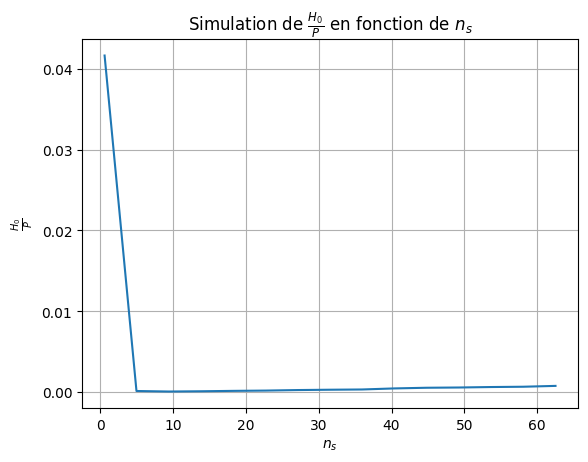

In [41]:
Ns = np.linspace(10, 1000, 15).astype(int)
num_iterations = 100
T = 100000
plot_function_ns_numba(previsibilite_numba, initialize, Ns, P, Np, M, T, epsilon, num_iterations,'$\\frac{H_0}{P}$')

Commentaires : La courbe révèle une tendance où $\frac{H_0}{P}$ commence à une valeur relativement élevée lorsque $n_s$ est proche de 0, puis chute rapidement pour atteindre un niveau très bas à mesure que le nombre de spéculateurs augmente. Cette chute indique que, avec très peu de spéculateurs, le système présente une certaine prévisibilité, mais celle-ci diminue rapidement à mesure que le nombre de spéculateurs augmente. Le système se stabilise rapidement à un niveau proche de zéro, suggérant que l'augmentation du nombre de spéculateurs réduit considérablement la prévisibilité du système. Ce comportement pourrait indiquer que, dans un environnement avec de nombreux spéculateurs, les interactions deviennent plus complexes et imprévisibles, réduisant ainsi la capacité à prédire les fluctuations du système. Même si on est en régime stationnaire, on a seulement la garantie que les fluctuations du système sont stables globalement (avec une variance et une valeur moyenne globalement constante) mais pas que les fluctuations sont prévisibles.

Cependant, au-delà d'un certain seuil, l'ajout de nombreux spéculateurs peut paradoxalement introduire une forme de régularité dans le chaos expliquant la très légère augmentation de la prévisibilité pour les plus grandes valeurs de $n_s$. Cela peut se produire parce que les actions des agents commencent à se compenser mutuellement, créant des motifs répétitifs ou des comportements collectifs qui augmentent légèrement la prévisibilité.

4. vérifier que $H_0 = 0$ n'est pas possible si $\epsilon > 0$.

In [42]:
def explore_H0_with_epsilon(initialization, Ns, P, Np, M, T, epsilon_values, num_iterations):
    """La fonction explore_H0_with_epsilon prend 8 arguments :
    - initialization : la fonction d'initialisation
    - Ns : le nombre de spéculateurs
    - P : le nombre d'états
    - Np : le nombre d'autres agents
    - M : le nombre de derniers signes de A(t) considérés
    - T : l'horizon de temps
    - epsilon_values : les valeurs de epsilon à tester
    - num_iterations : le nombre d'itérations pour chaque epsilon
    On retourne une liste de valeurs de H_0 pour chaque epsilon."""
    H_0_values = []
    for epsilon in epsilon_values:
        H_0 = np.mean([previsibilite_numba(initialization, Ns, P, Np, M, T, epsilon) for _ in range(num_iterations)]) / P
        H_0_values.append(H_0)
    return H_0_values

In [46]:
epsilon_values = np.logspace(-5, 0, 10)
Ns = 1000
T = 100000

In [59]:
def plot_function_epsilon(function, initialize, Ns, P, Np, M, T, epsilon, num_iterations, title):
    """La fonction prend 10 arguments :
    - function : le nom de la fonction que l'on va utiliser pour afficher soit les fluctuations soit la prévisibilité
    - initialize : la fonction qui permet d'initialiser
    - Ns : le nombre de spéculateurs
    - P : le nombre d'états
    - Np : le nombre d'autres agents
    - M : le nombre de derniers signes de A(t) considérés
    - T : l'horizon temporel
    - epsilon : la performance minimale
    - num_iterations : le nombre d'itérations de l'aglorithme pour effecteur la moyenne
    - title : le nom de la grandeur que l'on affiche sur le graphique
    On affiche le graphique à la fin."""
    grandeur = explore_H0_with_epsilon(initialize, Ns, P, Np, M, T, epsilon_values, num_iterations)
    plt.plot(epsilon, grandeur)
    plt.xlabel('$\epsilon$')
    plt.ylabel(title)
    plt.title(f'Simulation de {title} en fonction de $\epsilon$')
    plt.grid()
    plt.show()
    minimum = min(grandeur)
    print("Minimum de H_0/P:", minimum)

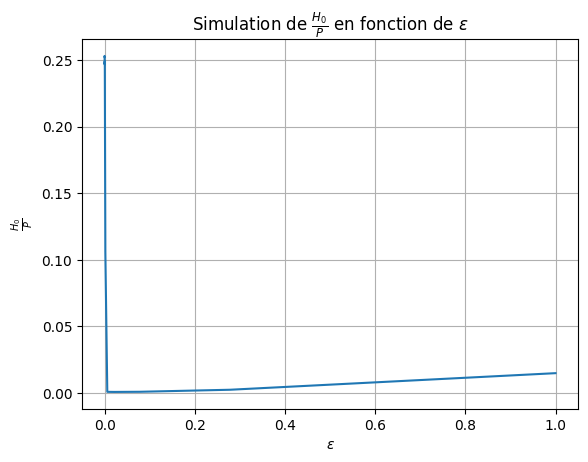

Minimum de H_0/P: 0.0006205411247837188


In [60]:
plot_function_epsilon(explore_H0_with_epsilon, initialize, Ns, P, Np, M, T, epsilon_values, num_iterations,'$\\frac{H_0}{P}$')

Commentaires : Ainsi, la courbe semble montrer que $H_0 = 0$ n'est pas possible lorsque $\epsilon > 0$. La borne observée, où $\frac{H_0}{P}$ reste très proche de zéro mais ne l'atteint jamais exactement (comme nous pouvons le voir selon le minimum affiché), est cohérente avec l'idée que l'introduction d'une performance minimale empêche le système d'atteindre une prévisibilité nulle. Cela confirme bien que la prévisibilité ne peut pas être exactement nulle lorsque $\epsilon$ est positif.

5. prendre $a_{i,μ} \sim P(a)$ où $P(a)$ est telle que $E(a) = 0$ et $E(a^2) = 1$. Y-a-t'il des différences perceptibles ?

Nous devons donc implémenter les stratégies des agents $a_{i,\mu}$ telles qu'elles suivent une distribution $P(a)$ avec une espérance nulle et une variance unité.

In [48]:
# Nous allons changer l'initialisation des stratégies en utilisant une loi normale d'espérance nulle et de variance égale à 1 afin de respecter les conditions de l'énoncé.

def initialize_normal(Ns, P, Np):

    # Cette fois-ci, nous initialisations les agents avec une loi normale.
    strategies = np.random.normal(0, 1, size=(Ns, P))
    performance = np.zeros(Ns)

    # On initialise Omega et mu
    Omega = np.random.normal(0, np.sqrt(Np), size=P)
    # On génère un nombre compris entre 0 et P-1 inclus.
    mu = np.random.randint(0, P)

    return strategies, performance, Omega, mu

In [49]:
T = 100
Ns = 10
P = 16
Np = 16
epsilon = 0.01
M = 3

In [51]:
strategies, performance, Omega, mu = initialize_normal(Ns, P, Np)
A_history, mu_history, performance = simulation_numba(strategies, performance, Omega, mu, Ns, P, Np, M, T, epsilon)
print("Final mu:", mu_history[-1])
print("Final A(t):", A_history[-1])
print("Top 5 performing agents:", np.argsort(performance)[-5:])

Final mu: 6
Final A(t): -0.37844419862001666
Top 5 performing agents: [6 1 7 4 2]


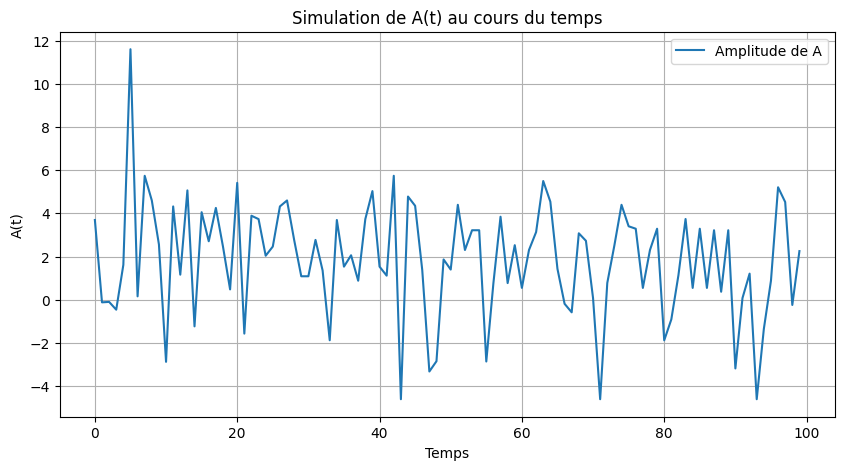

In [52]:
plot_simulation(initialize_normal, Ns, P, Np, M, T, epsilon)

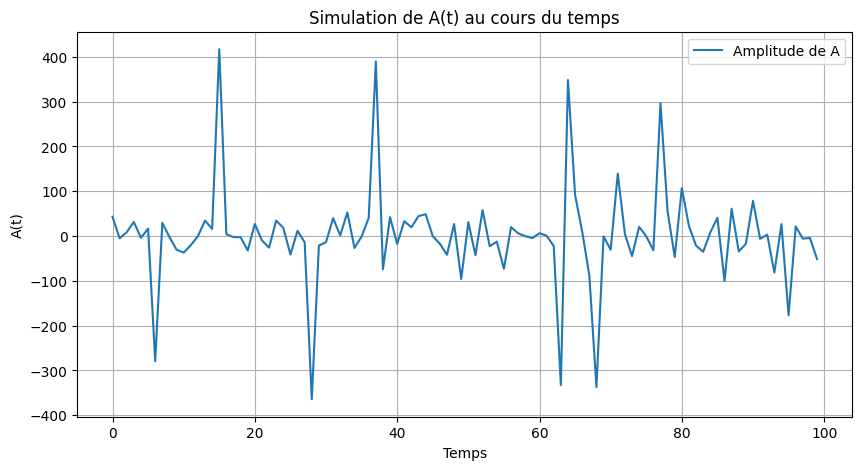

In [53]:
T = 100
Ns = 1000
plot_simulation(initialize_normal, Ns, P, Np, M, T, epsilon)

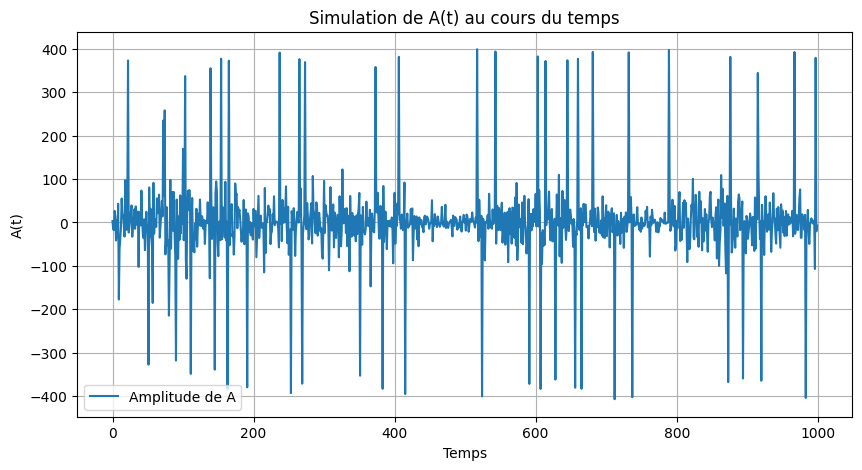

In [54]:
T = 1000
plot_simulation(initialize_normal, Ns, P, Np, M, T, epsilon)

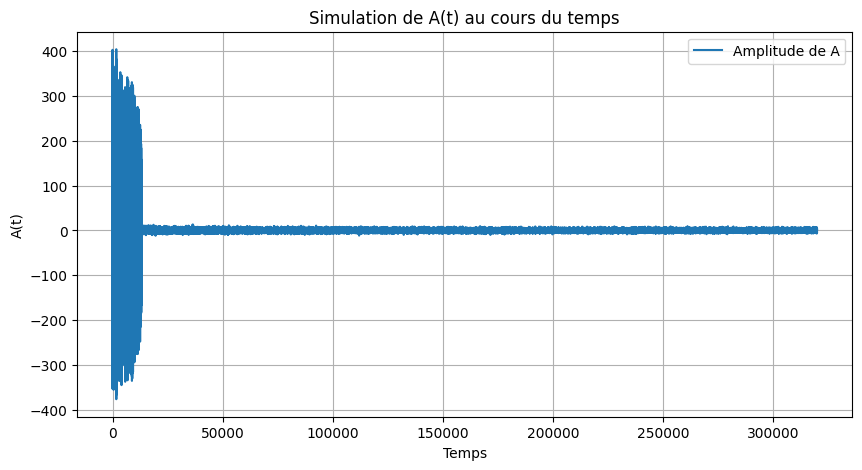

In [55]:
T = int(200*P/epsilon)
plot_simulation(initialize_normal, Ns, P, Np, M, T, epsilon)

Commentaires : pour le moment, nous pouvons observer des résultats similaires avec une explosion de l'amplitude de $A(t)$ pour un grand nombre de spéculateurs. Le régime stationnaire semble être atteint aussi rapidement que précédemment mais les amplitudes en régime stationnaire sont beaucoup plus faibles.

Cette caractéristique peut être dû à la flexibilité et à la diversité des stratégies initiales des agents offertes par l'initialisation avec une loi normale, qui permettent une compensation plus fine des actions et une réduction des fluctuations globales du système. Cette observation est cohérente avec les caractéristiques des systèmes complexes où la diversité des comportements initiaux peut conduire à une plus grande stabilité.

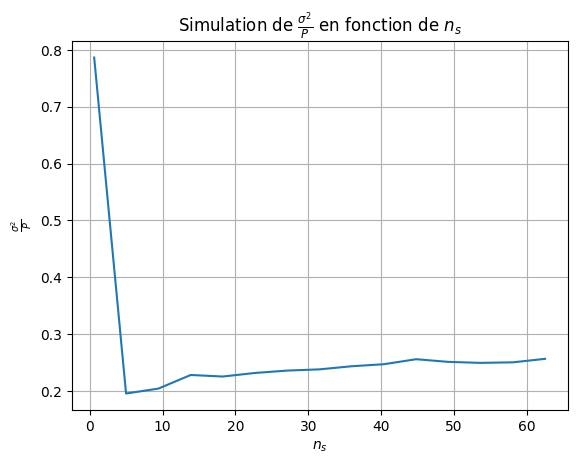

In [56]:
T = 100000
Ns = np.linspace(10, 1000, 15).astype(int)
num_iterations = 100
plot_function_ns_numba(compute_sigma_2_numba, initialize_normal, Ns, P, Np, M, T, epsilon, num_iterations,'$\\frac{\sigma^2}{P}$')

Commentaires : Le graphique ci-dessus montre que l'initialisation des stratégies avec une distribution normale conduit à des fluctuations plus faibles dans le système, en particulier à mesure que le nombre de spéculateurs augmente. En effet, la croissance après le minimum est bien plus faible que préccédemment avec une initialisation binaire. Cela s'explique par la capacité des stratégies continues à permettre des interactions plus équilibrées et compensées entre les agents, aboutissant à un système plus stable avec des fluctuations réduites. Ce comportement est cohérent avec l'attente que des stratégies diverses et flexibles peuvent mener à des dynamiques plus stables dans des systèmes complexes comme celui-ci.

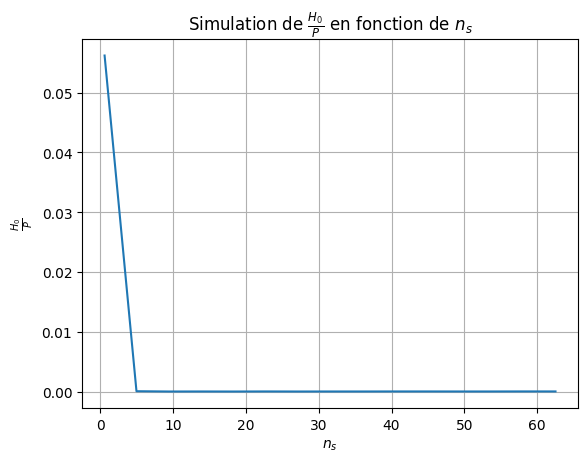

In [57]:
plot_function_ns_numba(previsibilite_numba, initialize_normal, Ns, P, Np, M, T, epsilon, num_iterations,'$\\frac{H_0}{P}$')

Commentaires : On observe une allure similaire à celle avec une initialisation binaire avec simplement aucune réaugmentation de la prévisibilité quand le nombre de spéculateurs augmente (elle s'observe peut être plus tard mais à échelle équivalente on ne peut pas s'en rendre compte). Avec une distribution normale, les stratégies sont plus diversifiées et continues, ce qui peut conduire à une dynamique différente par rapport à une initialisation binaire et donc à plus de difficulté à obtenir à nouveau de la prévisibilité par compensation des actions de tous les agents (ce qui est beaucoup plus dur à avoir si on initialise les stratégies avec une loi normale).

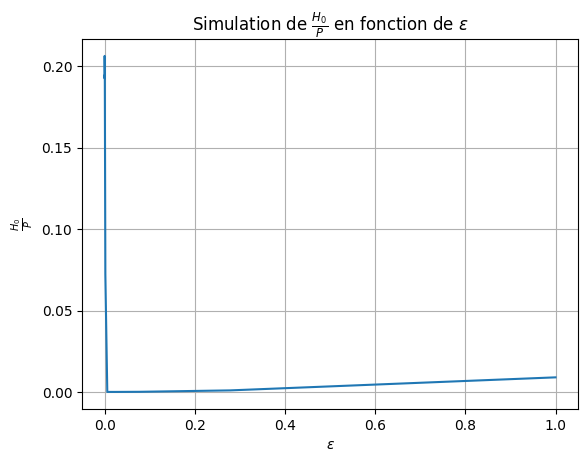

Minimum de H_0/P: 8.47566926241029e-05


In [61]:
epsilon_values = np.logspace(-5, 0, 10)
Ns = 1000
T = 100000
plot_function_epsilon(explore_H0_with_epsilon, initialize_normal, Ns, P, Np, M, T, epsilon_values, num_iterations,'$\\frac{H_0}{P}$')

Commentaires : On remarque un comportement très similaire pour l'évolution de la prévisibilité en fonction de la performance minimale requise pour les agents. Le minimum est non nul ce qui prouve bien ce qui est demandé.